In [ ]:
!git clone https://github.com/d-uni/LPPL_model.git
%cd LPPL_model

Cloning into 'LPPL_model'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 22), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 612.69 KiB | 6.88 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/LPPL_model/LPPL_model/LPPL_model/LPPL_model/LPPL_model


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from model_lppls import ModelLPPLS
from rolling_calibrator import RollingLPPLCalibrator
from distribution_calibrators import (
    DistributionLPPLCalibrator_for_different_Windows,
    DistributionLPPLCalibrator_for_different_Dates,
)
from visualization import plot_lppls_results, plot_tc_distribution,plot_combined_tc_distributions
from tqdm import tqdm


In [ ]:


# --- Download S&P500 data ---
SYMBOL = "^GSPC"
data = yf.download(SYMBOL, start="2009-01-01", end="2011-01-01",
#                    progress=False, auto_adjust=True)["Close"].dropna()
#data = yf.download(SYMBOL, start="2010-01-01", end="2015-01-01",
                   progress=False, auto_adjust=True)["Close"].dropna()

p_series = data.values.squeeze()

# --- Compute daily returns ---
returns = (p_series[1:] - p_series[:-1]) / p_series[:-1]
returns = pd.Series(returns.flatten(), index=data.index[1:])

# --- Baseline strategy: always 100% long ---
equity_baseline = [1.0]  # start with $1
for r in returns:
    equity_baseline.append(equity_baseline[-1] * (1 + r))

equity_baseline = pd.Series(equity_baseline[1:], index=returns.index)

# --- Compute key performance metrics ---
annual_return = (equity_baseline.iloc[-1] / equity_baseline.iloc[0]) ** (252 / len(returns)) - 1
annual_volatility = returns.std() * np.sqrt(252)
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)
max_drawdown = ((equity_baseline / equity_baseline.cummax()) - 1).min()

In [ ]:
# --- Display metrics ---
metrics = pd.DataFrame({
    "Annual Return": [annual_return],
    "Annual Volatility": [annual_volatility],
    "Sharpe Ratio": [sharpe_ratio],
    "Max Drawdown": [max_drawdown]
})
print("\n=== Baseline (Always Long) Performance Metrics ===")
print(metrics.round(4))



=== Baseline (Always Long) Performance Metrics ===
   Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown
0         0.1648             0.2303        0.7674       -0.2762


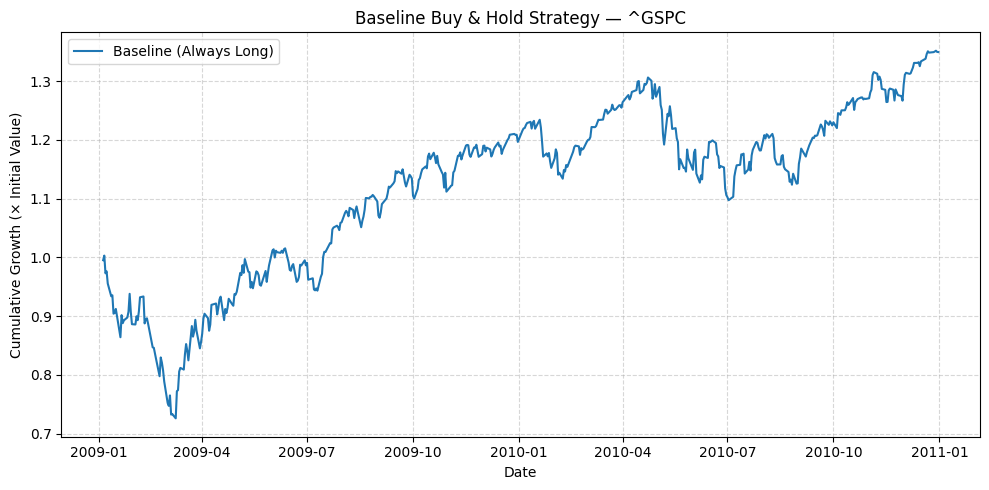

In [ ]:
# --- Plot cumulative equity curve ---
plt.figure(figsize=(10, 5))
plt.plot(equity_baseline, lw=1.5, label="Baseline (Always Long)")
plt.title(f"Baseline Buy & Hold Strategy — {SYMBOL}")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth (× Initial Value)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


**1. Strategy Motivation**

The Log-Periodic Power Law (LPPL) model captures speculative bubbles by fitting super-exponential price growth and oscillatory corrections.
We exploit this model in real time by converting LPPL forecasts into a dynamic trading exposure:

	•	w = 1 → fully invested
	•	w < 1 → reduced exposure (defensive stance)
	•	w > 1 → increased exposure (aggressive stance, mild leverage)

Exposure depends on two factors:

① LPPL Crash Probability

We estimate how close we are to a predicted crash time t_c:

	•	If LPPL predicts t_c near the current date → crash probability increases
	•	Higher crash probability → lower portfolio exposure

② LPPL Bubble Sign

	•	Positive sign (+) → red bubble → market accelerating upward before a crash → we reduce exposure (defensive)

	•	Negative sign (–) → green anti-bubble → market in recovery phase → we increase exposure (aggressive)


**2. Two Types of LPPL Calibrations**

At each day we run two sets of LPPL fits:

**A. Over different window sizes**

We keep the target date fixed, but change the historical window length.
This produces a distribution of predicted crash times t_c.

**B. Over different calibration dates**

We keep the window size fixed, but shift the calibration date backward in time.
This gives another independent distribution of t_c.

Each calibration also gives:

	•	LPPL parameters
	•	bubble sign
	•	calibration quality (R², RMSE, κ)

Only fits that pass acceptance criteria are used.

**3. KDE: How We Pick the “Best” Parameters**

We often get many different t_c predictions from many LPPL fits.
To combine them, we use `Kernel Density Estimation (KDE)`.


**4. Crash Probability Computation**

From both distributions (window-based and date-based), we compute:

$\Delta t = t_c - t_{\text{current}}$

We then apply KDE to estimate:

$P_{\text{crash}} = \mathbb{P}(0 < \Delta t < 0.25 \text{ years})$

This probability measures how likely LPPL thinks a crash is coming soon.

To combine both signals, we use the geometric mean:

$P_{\text{crash}}^{\text{final}} = \sqrt{
P_{\text{crash}}^{(w)} \cdot P_{\text{crash}}^{(d)}
}$

5. Final Exposure Rule

Exposure (weight) is determined by bubble sign:

Red Bubble (upward bubble → danger)

$w = 1 - \alpha \cdot P_{\text{crash}}$

	•	reduces exposure
	•	becomes more defensive as crash probability rises

Green Bubble (anti-bubble → recovery)

$w = 1 + \beta \cdot P_{\text{crash}}$

	•	increases exposure
	•	uses crash distance as a proxy for rebound strength

Weights are clipped to avoid extreme leverage:

$w \in [0.2,\, 2.5]$

In [ ]:
# --- Convert dates to fractional years (for LPPL) ---
t_series = (data.index - data.index[0]).days / 365.25

# --- Instantiate calibrators ---
cal_window = DistributionLPPLCalibrator_for_different_Windows(t_series, p_series)
cal_window.set_model_params_initial_guess(tc_offset=0.12, m0=0.55, omega0=9.0)
cal_window.set_acceptance_thresholds(r2_min=0.9, rmse_max=0.06, kappa_min=0.05, tc_horizon_years=0.5)

cal_date = DistributionLPPLCalibrator_for_different_Dates(t_series, p_series)
cal_date.set_model_params_initial_guess(tc_offset=0.12, m0=0.55, omega0=9.0)
cal_date.set_acceptance_thresholds(r2_min=0.9, rmse_max=0.06, kappa_min=0.05, tc_horizon_years=0.5)

# --- Backtest setup ---
returns = (p_series[1:] - p_series[:-1]) / p_series[:-1]
returns = pd.Series(returns.flatten(), index=data.index[1:])

dates = returns.index
t_values = (dates - data.index[0]).days / 365.25

weights = []
parameters_ = []
alpha = 2.0   # defensive sensitivity
beta = 3.0    # aggressive sensitivity (leverage during rebound)

# --- Rolling simulation ---
for t_current, target_d in tqdm(zip(t_values, dates), desc="Running LPPL directional strategy"):
    # Skip if too early (not enough history)
    if t_current < 1.5:
        weights.append(1.0)
        continue

    # --- Across different window sizes ---
    dist_w = cal_window.tc_distribution_over_window(
        target_date=t_current,
        min_window_years=1/12,   # 1 month
        max_window_years=1.0,    # 1 year
        step_window_years=10/365.25,
        acceptance_thresholds=True
    )

    if dist_w.empty or "tc" not in dist_w.columns:
        weights.append(1.0)
        continue

    # Pick most "imminent" window (tc closest to t_current + 0.25y)
    dist_w["delta"] = np.abs(dist_w["tc"] - (t_current + 0.25))
    best_row = dist_w.loc[dist_w["delta"].idxmin()]
    best_window = best_row["window_years"]

    # --- Across different calibration dates ---
    dist_d = cal_date.tc_distribution_over_dates(
        target_date=t_current,
        window_years=best_window,
        distribution_window_years=1/12,
        step_years=1/365.25,
        acceptance_thresholds=True
    )

    # Skip invalid
    if dist_d.empty or len(dist_w) < 3 or len(dist_d) < 3:
        weights.append(1.0)
        continue

    # --- Compute directional bubble signal ---
    # Mean bubble sign across both calibrations
    sign_mean = np.mean(np.concatenate([dist_w["sign"].values, dist_d["sign"].values]))

    # Positive sign → green (upward bubble, usually pre-crash)
    # Negative sign → red (anti-bubble, recovery phase)

    # --- Compute crash proximity probabilities ---
    tc_w = dist_w["tc"].values
    tc_d = dist_d["tc"].values
    delta_w = tc_w - t_current
    delta_d = tc_d - t_current

    if len(delta_w) < 2 or len(delta_d) < 2:
        weights.append(1.0)
        continue

    kde_w = gaussian_kde(delta_w)
    kde_d = gaussian_kde(delta_d)
    crash_prob_w = kde_w.integrate_box_1d(0, 0.25)
    crash_prob_d = kde_d.integrate_box_1d(0, 0.25)
    crash_prob = np.sqrt(crash_prob_w * crash_prob_d)

    # --- Compute exposure based on bubble polarity ---
    if sign_mean > 0:
        # Red bubble → approaching instability → go defensive
        # Lower exposure as crash probability increases
        w = 1 - alpha * crash_prob

    else:
        # Green bubble (anti-bubble) → recovery phase
        # Increase exposure (even leverage slightly)
        w = 1 + beta * crash_prob

    # --- Stabilize and clip ---
    w = np.clip(w, 0.2, 2.5)  # never fully short, cap leverage to 2.5x
    weights.append(w)

    parameters_.append({
        "date": target_d,
        "sign": sign_mean,
        "crash_prob": crash_prob,
        "weight": w
    })

# --- Align and backtest ---
weights = pd.Series(weights, index=dates).reindex(returns.index, method="ffill")
strategy_returns = weights.shift(1).fillna(1.0) * returns
equity_lppl = (1 + strategy_returns).cumprod()

Running LPPL directional strategy: 503it [04:46,  1.76it/s]



=== Performance Comparison ===
               Return     Vol  Sharpe     MDD
Baseline       0.1648  0.2303  0.7674 -0.2762
LPPL-Adaptive  0.2113  0.2366  0.9183 -0.2762


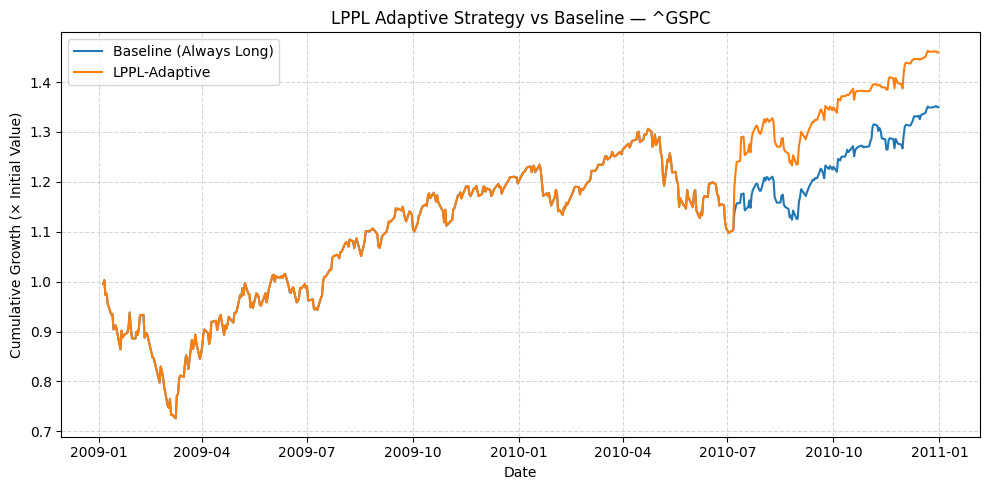

In [ ]:

# --- Performance metrics ---
def compute_metrics(rets, eq):
    annual_return = (eq.iloc[-1] / eq.iloc[0]) ** (252 / len(rets)) - 1
    annual_vol = rets.std() * np.sqrt(252)
    sharpe = (rets.mean() / rets.std()) * np.sqrt(252)
    max_dd = ((eq / eq.cummax()) - 1).min()
    return dict(Return=annual_return, Vol=annual_vol, Sharpe=sharpe, MDD=max_dd)

metrics = pd.DataFrame([
    compute_metrics(returns, equity_baseline),
    compute_metrics(strategy_returns, equity_lppl)
], index=["Baseline", "LPPL-Adaptive"])

print("\n=== Performance Comparison ===")
print(metrics.round(4))

# --- Plot comparison ---
plt.figure(figsize=(10, 5))
plt.plot(equity_baseline, label="Baseline (Always Long)", lw=1.5)
plt.plot(equity_lppl, label="LPPL-Adaptive", lw=1.5)
plt.title(f"LPPL Adaptive Strategy vs Baseline — {SYMBOL}")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth (× Initial Value)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
distributions_array[22][0]


,window_years,tc,A,B,C1,C2,m,omega,r2,rmse,kappa,sign,delta
0,0.083333,2.286250,7.305163,-0.460452,0.067670,-0.007276,0.807254,12.999971,0.917467,0.003947,0.460452,1,0.178671
1,0.110712,2.245939,7.565163,-0.440883,-0.011984,0.004917,0.100000,7.361201,0.901464,0.004501,0.440883,1,0.218982
2,0.165469,2.238287,7.519669,-0.386171,0.007505,-0.009626,0.100000,6.124167,0.933258,0.005244,0.386171,1,0.226634
3,0.192847,2.240956,7.325813,-0.228019,0.018078,-0.003843,0.308701,6.000000,0.938210,0.005721,0.228019,1,0.223965
4,0.220226,2.251896,7.277575,-0.278010,0.021508,0.021901,0.676505,6.000000,0.955653,0.005905,0.278010,1,0.213025
5,0.247604,2.268368,7.272467,-0.363514,-0.009214,0.034176,0.899976,6.000002,0.960315,0.006275,0.363514,1,0.196553
6,0.302361,2.277217,7.281731,-0.368813,-0.027014,0.030487,0.857678,6.000010,0.950395,0.009365,0.368813,1,0.187704
7,0.329740,2.305449,7.296088,-0.406686,-0.028941,-0.003570,0.898746,6.000021,0.934994,0.011835,0.406686,1,0.159472
8,0.357118,2.494926,9.072580,-2.059697,-0.011718,-0.003893,0.100000,10.274058,0.921772,0.013920,2.059697,1,0.030005
9,0.384497,2.278765,7.275155,-0.361847,-0.045881,0.036193,0.899890,6.000005,0.903313,0.015268,0.361847,1,0.186156


In [ ]:
len(distributions_array)

63

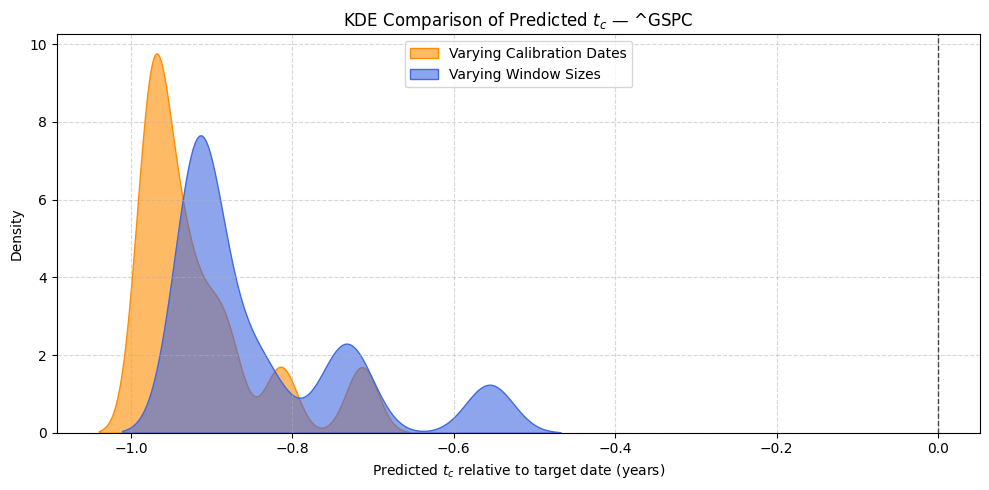

In [ ]:
i = 20
tc_w = distributions_array[i][0]["tc"] - (target_date_[i] - data.index[0]).days / 365.25
tc_d = distributions_array[i][1]["tc"] - (target_date_[i] - data.index[0]).days / 365.25
plot_combined_tc_distributions(tc_w, tc_d, symbol=SYMBOL)

In [ ]:
parameters_[i]


{'date': Timestamp('2010-11-10 00:00:00'),
 'sign': np.float64(1.0),
 'crash_prob': np.float64(0.4983170382066558),
 'weight': np.float64(0.2)}